**By Akinde Kadjo**, 04/10/2023

**Introduction:** ABL1 ( or Tyrosine-protein kinase ABL) gene provides instructions for making a protein involved in many processes in cells throughout the body. In response to growth factors, cytokines, cell adhesion, DNA damage, oxidative stress, and other signals, ABL is activated to stimulate cell proliferation or differentiation, survival or death, retraction, or migration; according to [Wang.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3993570/#:~:text=The%20mammalian%20ABL1%20gene%20encodes,death%2C%20retraction%2C%20or%20migration.)

**Objective:** The goal of this project is to use the [DUDE-E](https://dude.docking.org/targets/abl1) data set for target against ABL1 to build a model that can accurately distinguish Active ligands from Decoy ligands (similar properties to actives but are known to be non-binders).

# Import and Data Loading

In [1]:
#!pip install rdkit-pypi (skipped if already installed)

In [2]:
#Importing all of the libraries that may be needed for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,roc_auc_score,PrecisionRecallDisplay, RocCurveDisplay,f1_score

from sklearn import set_config
set_config(display='diagram')

import warnings
warnings.filterwarnings('ignore')

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

In [3]:
#Create a function to export the Physical properties of choice from the files files into a dataframe
def extract(file):
    suppl = Chem.SDMolSupplier(file)
    mol_len = len(suppl)
    df = pd.DataFrame()
    
    for i in range(mol_len):
        mol = suppl[i]
        if mol is not None:
            df.loc[i,'smiles'] = Chem.MolToSmiles(mol)
            df.loc[i,'chemblid'] = mol.GetProp('_Name')
            df.loc[i,'MW'] = Descriptors.ExactMolWt(mol)
            df.loc[i,'asphericity'] = rdMolDescriptors.CalcAsphericity(mol)
            df.loc[i,'eccentricity'] = rdMolDescriptors.CalcEccentricity(mol)
            df.loc[i,'sp3'] = rdMolDescriptors.CalcFractionCSP3(mol)
            df.loc[i,'inertia'] = rdMolDescriptors.CalcInertialShapeFactor(mol)
            df.loc[i,'asa'] = rdMolDescriptors.CalcLabuteASA(mol)
            df.loc[i,'ar_rings'] = rdMolDescriptors.CalcNumAromaticRings(mol)
            df.loc[i,'al_rings'] = rdMolDescriptors.CalcNumAliphaticRings(mol)
            df.loc[i,'stereoCenters'] = rdMolDescriptors.CalcNumAtomStereoCenters(mol)
            df.loc[i,'atoms'] = rdMolDescriptors.CalcNumAtoms(mol)
            df.loc[i,'heavyatoms'] = rdMolDescriptors.CalcNumHeavyAtoms(mol)
            df.loc[i,'pbf'] = rdMolDescriptors.CalcPBF(mol)
            df.loc[i,'gyration'] = rdMolDescriptors.CalcRadiusOfGyration(mol)
            df.loc[i,'tpsa'] = rdMolDescriptors.CalcTPSA(mol)
            df.loc[i,'logp'] = Descriptors.MolLogP(mol)
            df.loc[i,'h_bond_donor'] = Descriptors.NumHDonors(mol) 
            df.loc[i,'h_bond_acceptor'] = Descriptors.NumHAcceptors(mol)
            df.loc[i,'num_rotatable_bonds'] = Descriptors.NumRotatableBonds(mol) 
            df.loc[i,'net_charge'] = Chem.GetFormalCharge(mol)
    print(df.shape)
    return df

In [4]:
active_df = extract('actives_final.sdf')
active_df.head(2)

(295, 21)


,smiles,chemblid,MW,asphericity,eccentricity,sp3,inertia,asa,ar_rings,al_rings,...,atoms,heavyatoms,pbf,gyration,tpsa,logp,h_bond_donor,h_bond_acceptor,num_rotatable_bonds,net_charge
0,Nc1ncnc2c1c(-c1cccc(O)c1)cn2C1CCC1,CHEMBL355330,280.132411,0.280987,0.930127,0.250000,0.000656,121.616651,3.0,1.0,...,37.0,21.0,0.443367,3.376660,76.96,3.1111,2.0,5.0,2.0,0.0
1,COc1ccccc1Oc1ccc2n[nH]c(-c3nc4ccc(N5CCC([NH+]6...,CHEMBL211508,523.281601,0.699540,0.993622,0.354839,0.000410,227.484450,5.0,2.0,...,74.0,39.0,0.672138,6.448559,83.50,4.9447,3.0,5.0,6.0,1.0


In [5]:
decoy_df = extract('decoys_final.sdf')
decoy_df.head(2)

(10885, 21)


,smiles,chemblid,MW,asphericity,eccentricity,sp3,inertia,asa,ar_rings,al_rings,...,atoms,heavyatoms,pbf,gyration,tpsa,logp,h_bond_donor,h_bond_acceptor,num_rotatable_bonds,net_charge
0,C[C@@H]1CCCC[C@@]12NC(=O)N(CC(=O)Nc1ccc(C(N)=O...,ZINC02649438,358.164105,0.633763,0.989822,0.444444,0.001058,150.644583,1.0,2.0,...,48.0,26.0,0.629443,4.359138,121.60,1.2247,3.0,4.0,4.0,0.0
1,C=C1NN(c2nc3ccccc3s2)C(=O)[C@@H]1/C=N/C(CO)(CO)CO,ZINC01814196,362.104876,0.616234,0.988628,0.312500,0.000984,147.281501,2.0,1.0,...,43.0,25.0,0.299550,4.330039,118.28,0.0639,4.0,8.0,6.0,0.0


# Classification analysis

In this part, I'll use both active and decoy Dataframes to predict how effective the compounds physical properties can be used to predict whether a ligand is active or not against the target ABL1.

## Data Cleaning

Here, I'll add a target column of 1 for the active ligands and 0 for the decoys.

In [6]:
#Adding target column
active_df['target'] = 1
decoy_df['target'] = 0
ligands_df =  pd.concat([active_df, decoy_df]) #Concacenating both dfs
#deleting duplicated data and missing values
ligands_df = ligands_df.drop_duplicates()
ligands_df.dropna(inplace=True)
#moving forward with only numeric columns
ligands_df = ligands_df.drop(columns=['smiles','chemblid'])

In [7]:
ligands_df.head(2)

,MW,asphericity,eccentricity,sp3,inertia,asa,ar_rings,al_rings,stereoCenters,atoms,heavyatoms,pbf,gyration,tpsa,logp,h_bond_donor,h_bond_acceptor,num_rotatable_bonds,net_charge,target
0,280.132411,0.280987,0.930127,0.250000,0.000656,121.616651,3.0,1.0,0.0,37.0,21.0,0.443367,3.376660,76.96,3.1111,2.0,5.0,2.0,0.0,1
1,523.281601,0.699540,0.993622,0.354839,0.000410,227.484450,5.0,2.0,0.0,74.0,39.0,0.672138,6.448559,83.50,4.9447,3.0,5.0,6.0,1.0,1


## Visual exploratory analysis


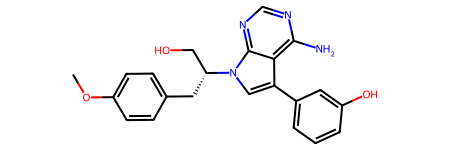

In [8]:
# Displaying an active ligand (randomly picked)
mol = Chem.MolFromSmiles(active_df['smiles'][5])
mol

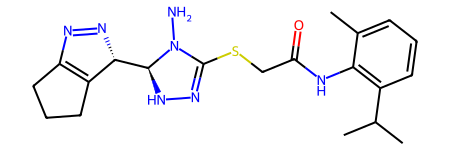

In [9]:
# Displaying an decoy ligand (randomly picked)
mol = Chem.MolFromSmiles(decoy_df['smiles'][9])
mol

In [10]:
##Creating a function for plotting histogram of the features
def feat_plot(y_list, plot_df):
  y_len = len(y_list)
  plot_df_0 = plot_df.loc[plot_df['target'] == 0]
  plot_df_1 = plot_df.loc[plot_df['target'] == 1]
  fig, axes = plt.subplots(2,y_len, figsize = (30, 6),constrained_layout=True)
  axes = axes.ravel()
  for i in range(y_len):
    sns.histplot(ax = axes[i],  x= plot_df_1[y_list[i]],color='blue')
    axes[i].set_title(f'Active {y_list[i]}')
    sns.histplot(ax = axes[i+y_len],  x= plot_df_0[y_list[i]],color='red')
    axes[i+y_len].set_title(f'Decoy {y_list[i]}')    
  return plt.show()

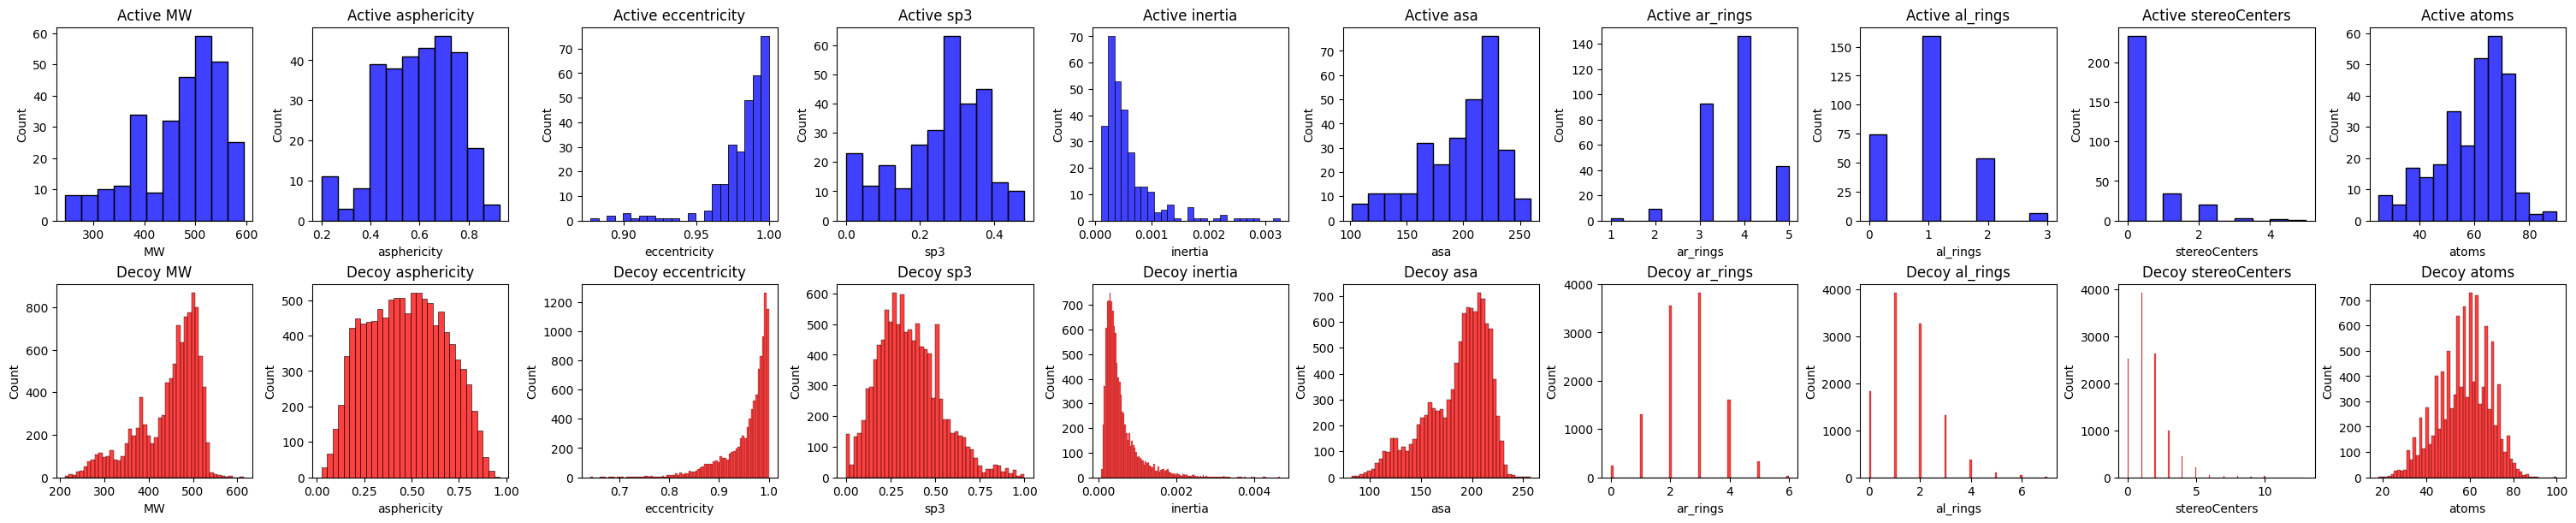

In [11]:
features = list(ligands_df.columns[:10])
feat_plot(features, ligands_df)

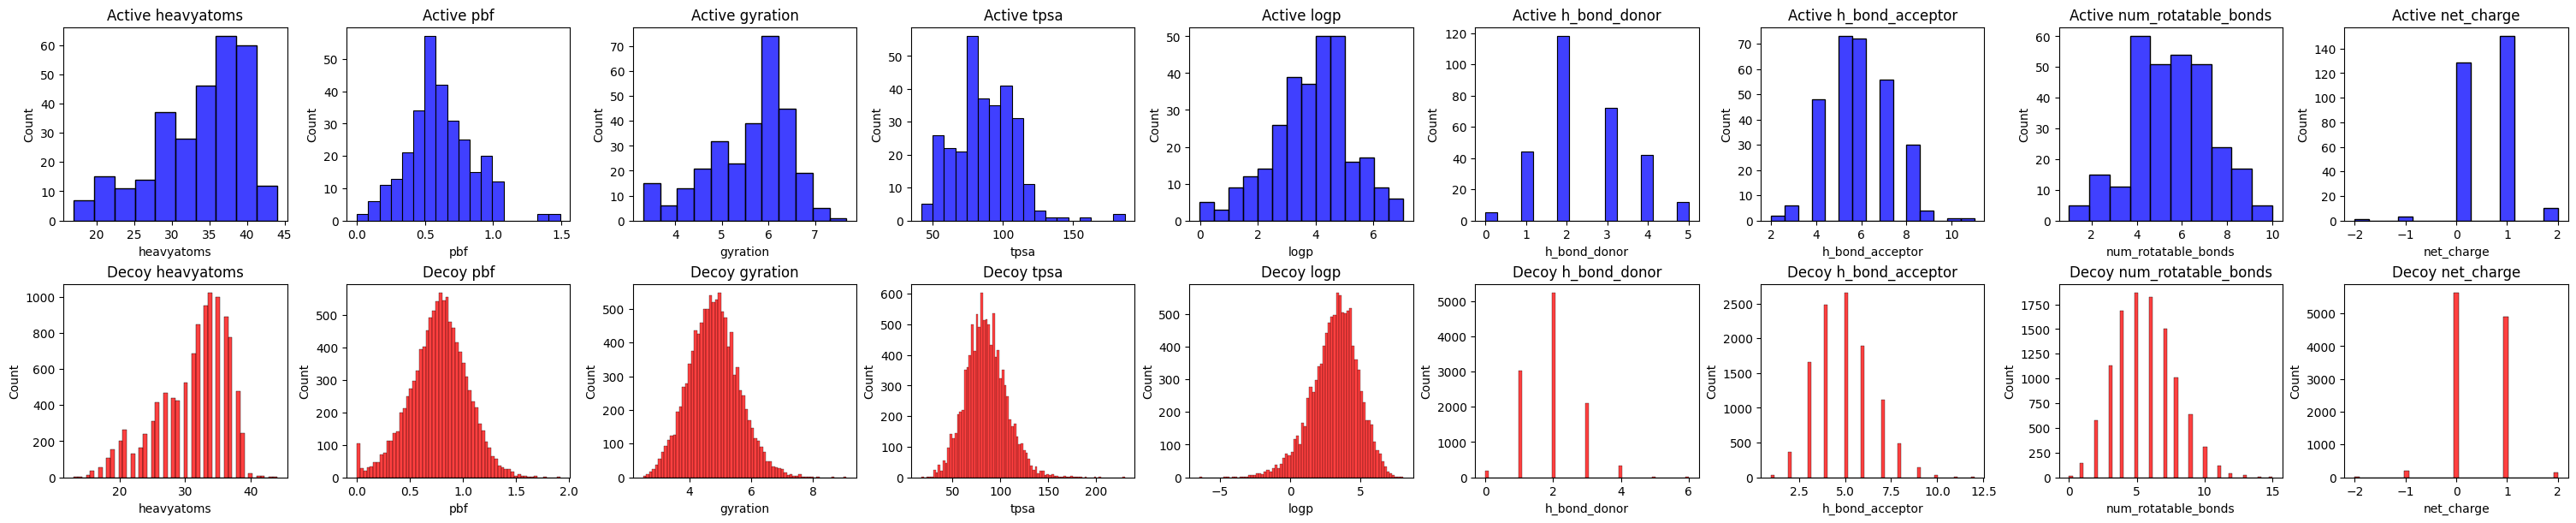

In [12]:
features = list(ligands_df.columns[10:-1])
feat_plot(features, ligands_df)

## ML Model

In [13]:
##I'm creating a function that will output the metrics for my model prediction evaluation
def evaluate_classiffication(model, X_test, y_test, label='Test Data', figsize=(10,3), normalize='true',cmap='Blues'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)
    ## Get Predictions
    y_pred = model.predict(X_test)     
    ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize=normalize, cmap=cmap, ax=axes[0])        
    RocCurveDisplay.from_estimator(model, X_test, y_test,ax=axes[1])
    plt.show()

In [14]:
#is the data balanced?
ligands_df['target'].value_counts(normalize=True)

0    0.973778
1    0.026222
Name: target, dtype: float64

This dataset is unbalanced, so some type of tuning will have to be applied

### Random forest model

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: the Test Data using Random Forest Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2726
           1       0.97      0.46      0.62        68

    accuracy                           0.99      2794
   macro avg       0.98      0.73      0.81      2794
weighted avg       0.99      0.99      0.98      2794



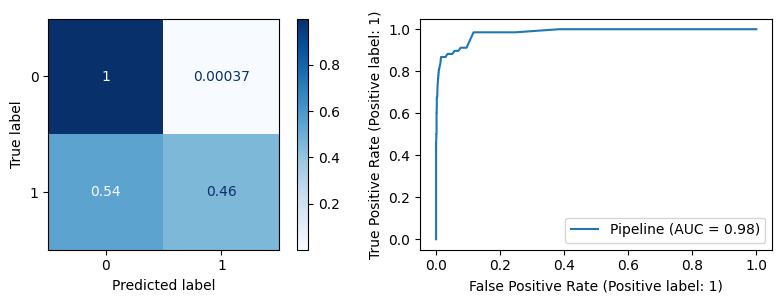

In [15]:
#Data Splitting and Preprocessing
y = ligands_df['target']
X = ligands_df.drop(columns='target')
#Performing a train test split, here the random state of 42 is chosen for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
# Instantiate Standard Scaler and random forest classification
scaler = StandardScaler() 
model = RandomForestClassifier(random_state=42)
# Setting up the pipeline and fitting the data
model_pipe = make_pipeline(scaler, model)
model_pipe.fit(X_train, y_train)
# Evaluating the model
evaluate_classiffication(model_pipe, X_test,y_test,label='the Test Data using Random Forest Regression')

Only 46% of the active ligands are predicted to be active, some tuning is needed here since the data is overwhelmingly unbalanced in favor of the decoy dataset.

### Random Forest with weight

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: the Test Data using Random Forest Regression with weight
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2726
           1       0.93      0.57      0.71        68

    accuracy                           0.99      2794
   macro avg       0.96      0.79      0.85      2794
weighted avg       0.99      0.99      0.99      2794



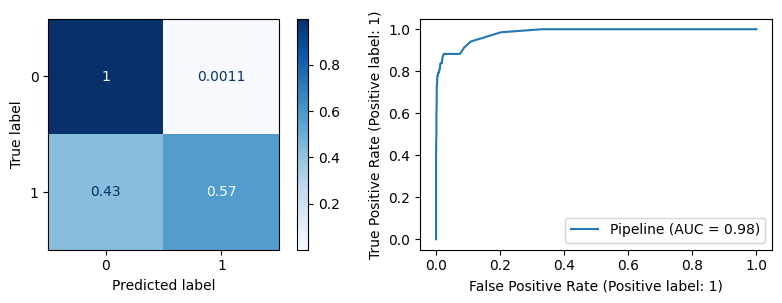

In [16]:
# Instantiate Standard Scaler and random forest classification
scaler = StandardScaler() 
model = RandomForestClassifier(random_state=42, class_weight= "balanced_subsample")
# Setting up the pipeline and fitting the data
model_pipe = make_pipeline(scaler, model)
model_pipe.fit(X_train, y_train)
# Evaluating the model
evaluate_classiffication(model_pipe, X_test,y_test,label='the Test Data using Random Forest Regression with weight')

Adding weight increased the recall to 57%.

Under sampling of the decoy dataset and using SMOTE (Synthetic Minority Oversampling TEchnique)to oversample the active dataset could help with the imbalanced data and increase both the f1 score and the AUC. 

 ### SMOTE (Synthetic Minority Oversampling TEchnique)

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: the Test Data using Random Forest Regression With SMOTE
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2726
           1       0.79      0.72      0.75        68

    accuracy                           0.99      2794
   macro avg       0.89      0.86      0.87      2794
weighted avg       0.99      0.99      0.99      2794



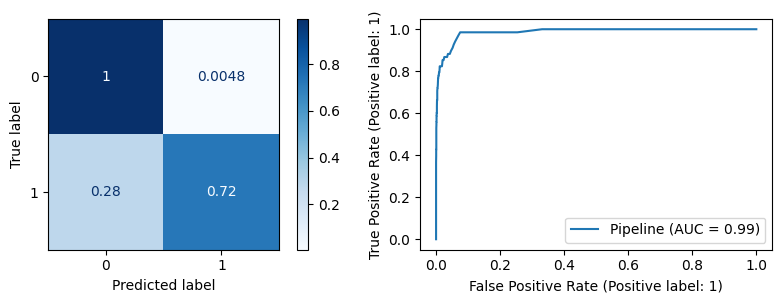

In [17]:
# Randomly over sample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)
# Instantiate Standard Scaler and random forest classification
scaler = StandardScaler() 
model = RandomForestClassifier(random_state=42)
# Setting up the pipeline and fitting the data
model_pipe = make_pipeline(scaler, model)
model_pipe.fit(X_train_smote, y_train_smote)
# Evaluating the model
evaluate_classiffication(model_pipe, X_test,y_test,label='the Test Data using Random Forest Regression With SMOTE')

### Random Under-Sampling

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: the Test Data using Random Forest Regression With RUS
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      2726
           1       0.15      0.91      0.26        68

    accuracy                           0.87      2794
   macro avg       0.57      0.89      0.59      2794
weighted avg       0.98      0.87      0.91      2794



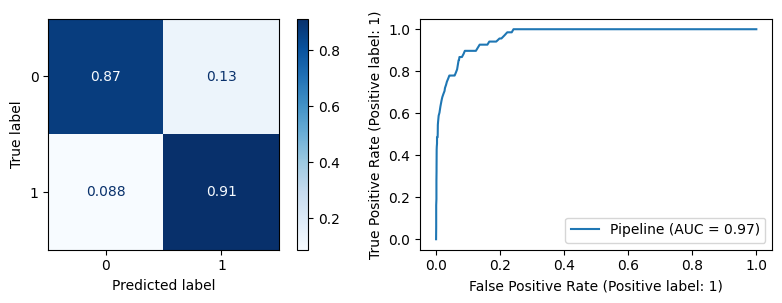

In [18]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)
# Instantiate Standard Scaler and random forest classification
scaler = StandardScaler() 
model = RandomForestClassifier(random_state=42)
# Setting up the pipeline and fitting the data
model_pipe = make_pipeline(scaler, model)
model_pipe.fit(X_train_rus, y_train_rus)
# Evaluating the model
evaluate_classiffication(model_pipe, X_test,y_test,label='the Test Data using Random Forest Regression With RUS')

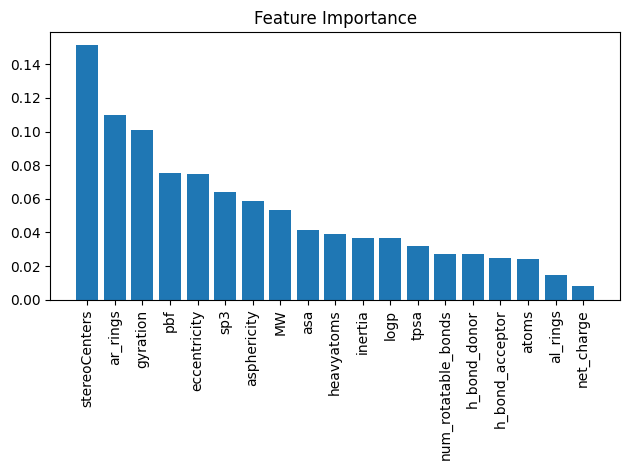

In [19]:
#Evaluating important features
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = ligands_df.columns[1:]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### Random Under-Sampling with most important features

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: the Test Data using Random Forest Regression With RUS
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      2726
           1       0.13      0.93      0.23        68

    accuracy                           0.85      2794
   macro avg       0.56      0.88      0.57      2794
weighted avg       0.98      0.85      0.90      2794



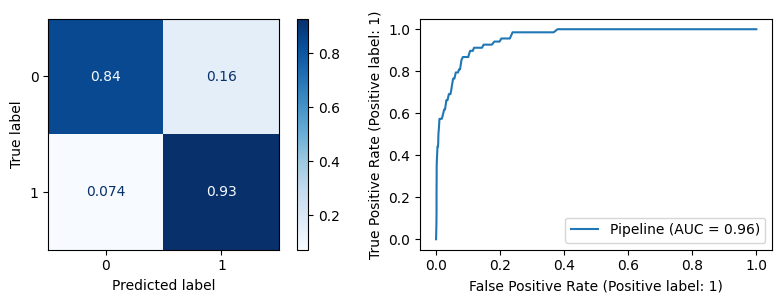

In [20]:
#Data Splitting and Preprocessing
y = ligands_df['target']
X = ligands_df[(X_train.columns[sorted_indices] [0:8])]
#Performing a train test split, here the random state of 42 is chosen for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)
# Instantiate Standard Scaler and random forest classification
scaler = StandardScaler() 
model = RandomForestClassifier(random_state=42)
# Setting up the pipeline and fitting the data
model_pipe = make_pipeline(scaler, model)
model_pipe.fit(X_train_rus, y_train_rus)
# Evaluating the model
evaluate_classiffication(model_pipe, X_test,y_test,label='the Test Data using Random Forest Regression With RUS')

## Cluster Visualization with PCA

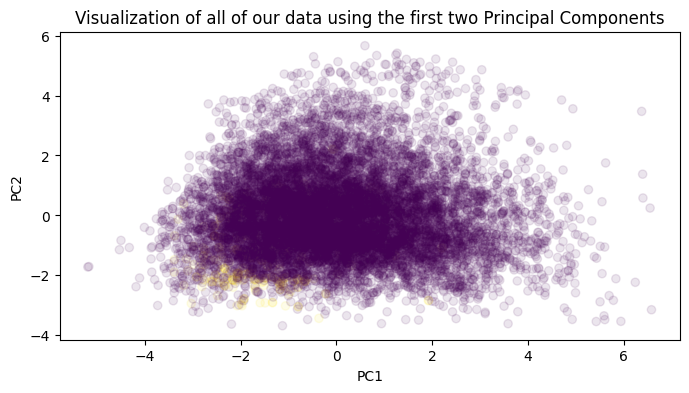

In [28]:
# Instantiate, fit & transform data using PCA
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
pca = PCA(n_components=2)
pcs = pca.fit_transform(scaled_df)

# Visualize the first 2 PCs
plt.figure(figsize = (8, 4))
plt.scatter(pcs[:,0], pcs[:,1],c= (ligands_df['target']), alpha=0.5)
plt.title('Visualization of all of our data using the first two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Conclusion

The best two models uses random under sampling to minimize the effects of the imbalanced data. 